# Data import and exploration
This notebook goes through data import and exploration using Numpy. You could also use Pandas to work with this data, but it's not very well suited to images. Regardless of which approach you choose, at some point you'll need to efficiently manipulate the images. Pandas is really good for tabular data, though,
and we'll use Pandas here to get some descriptive statistics about our target values (energies and positions).

## First, look at the data
Sean Liddick provided information about how the file is formatted:

The file contains one event per line, including the event energies and positions.
The values are space-separated. The first 256 values correspond to the 16x16 detector image, flattened. 
The next values are, in order:
Energy1, Xpos1, Ypos1, Energy2, Xpos2, Ypos2
There are two types of events in the dataset. Single and double.\
For single events Xpos2 and Ypos2 are set to -100 instead of 0 to make a clear distinction.\
The energy units are MeV, and the position units are in pixels. Each pixel corresponds to one sensor,
and is roughly equivalent to 3x3mm

Open up the file and look at it. In most linux terminals you can also use the command
`head` to display a set number of lines from the start of the file. We'll start with the first line.
Usually you will also have some information about the file formatting.
You can run shell commands inside the notebook by starting the line with an exclamation mark.

In [24]:
!head -1 ../data/CeBr10k_1.txt

53 81 96 117 175 194 229 221 179 112 112 80 74 51 36 29 73 92 140 187 253 385 480 395 298 221 145 101 73 59 52 43 64 131 165 261 405 760 1161 864 458 275 180 101 97 68 60 41 79 126 171 287 654 1808 4037 2244 759 350 197 133 86 78 58 35 75 130 153 324 731 2248 6480 3036 889 358 170 116 105 101 65 39 67 127 171 270 559 1158 1840 1324 618 287 172 103 104 78 75 39 48 95 120 185 366 485 628 496 360 213 152 111 90 70 69 36 58 73 109 149 157 229 280 268 243 172 142 106 81 73 73 40 44 66 88 115 126 148 125 156 118 127 122 119 103 108 87 73 34 49 68 71 104 112 117 107 100 108 128 138 172 134 142 93 37 46 54 52 66 67 88 91 98 109 151 210 284 309 234 144 22 47 43 56 69 63 63 68 109 113 177 372 743 781 429 228 18 34 42 42 40 59 57 76 70 118 220 541 1633 1769 543 230 32 33 36 46 42 46 56 64 74 93 207 435 935 957 501 204 12 34 28 38 37 35 45 59 82 98 154 251 343 393 256 173 13 21 27 34 36 37 27 35 42 63 109 144 162 191 136 115 0.942514 4.30804 6.70703 0.33576 12.6208 13.0421


That last bit of information indicates that the event we printed above is a double event.
We also note that the 256 "pixel" values in the detector image are integers, while the remaining
6 values for energy and position are floats.

## Data import
This is a bit of a "hands-on" approach that focuses on using base functions in python and
Numpy to read the file and create some arrays we can work with.
Reading the file is pretty straightforward, but some challenges appear when the file is large.
We will prepare for that scenario from the get-go.

CeBr10k_1.txt containes 10000 mixed single and double events.\
We set a datapath and filename. Note that we use the 'relative' path to our data, from the
location of the notebook. This works well in a github repo where you control the folder structure.
And if someone else will clone or fork the repo, they don't need to replace the paths.

For small datafiles you can read the entire file into memory, store it as a list where each element is a line in the file, and work from there.
```python
with open(DATA_PATH + fname, "r") as datafile:
    data = datafile.readlines()
```
You now have a list `data` containing all the lines in the file. Using the `with` statement is a shortcut so
we don't need to manually close the file after opening it.
However, reading the entire file into memory might not be possible, so we will read it line by line instead,
looping over the file. This read only one line into memory at a time.

Some resources for this exercise
* [Python I/O File handling](https://docs.python.org/3/tutorial/inputoutput.html#reading-and-writing-files)
* [Numpy array indexing](https://numpy.org/doc/1.18/reference/arrays.indexing.html)
* [Numpy's fromstring() function](https://numpy.org/doc/1.18/reference/generated/numpy.fromstring.html)

In [25]:
# Import the numpy module
import numpy as np

In [26]:
# Set path to data and filename. You can also store it a single variable
# DATA_PATH = "../data/CeBr10k_1.txt" if you prefer. Here we expect to use at least the path itself later,
# so we separate them.
DATA_PATH = "../data/"
fname = "CeBr10k_1.txt"

In [27]:
# Lists to store each image, energy, position, and labels. We know the filesize, so we could create
# arrays that perfectly match the data, but let's assume we don't know how many lines we're going to
# read. 
images = []
energies = []
positions = []
labels = []
# Open the file
with open(DATA_PATH + fname, "r") as datafile:
    # Loop over the file, line by line
    for line in datafile:
        
        # The line is still a string when read from the file. We use numpys fromstring()
        # to convert the line to a numpy array, specifying that each element is separated
        # by a space. This does not convert the line in the file, only the "copy" that we have
        # read into memory. fromstring() also removes any trailing newline ('\n') characters
        # so we don't have to worry about that. The values will be interpreted as floats.
        line = np.fromstring(line, sep=' ')
        
        # Now we pick slices of the array. The first 256 elements are 'pixels' of the detector image
        image = line[:256]
        
        # Get the two energies, at index 256 and 259.
        energy = np.array((line[256], line[259]))
        
        # And the four position values
        pos = np.array((line[257], line[258], line[260], line[261]))

        # Set label for the event. If Energy2 is 0 it is a single event. Any other values corresponds 
        # to a double event. We label single events as type 0, and doubles as type 1. We could also 
        # use Xpos2 or Ypos2 for this purpose.
        if energy[1] == 0:
            label = 0
        else:
            label = 1

        # Finally, we take the separated arrays and add them to their respective "storage" lists.
        images.append(image)
        energies.append(energy)
        positions.append(pos)
        labels.append(label)

        
# We've now looped over the entire file. The only thing that remains is to convert the lists
# to numpy arrays.
images = np.array(images)
energies = np.array(energies)
positions = np.array(positions)
labels = np.array(labels)

In [28]:
# We print the shape of the arrays we've made as a quick check using
# the shape property of numpy arrays.
print("Images shape:", images.shape)
print("Energies shape:",energies.shape)
print("Positions shape:", positions.shape)
print("Labels shape:", labels.shape)

Images shape: (10000, 256)
Energies shape: (10000, 2)
Positions shape: (10000, 4)
Labels shape: (10000,)


The output above tells us that we've got 10000 images, each of length 256, as well as two energy values for each image, and four positions. The images, energies, and positions arrays have two dimensions, while the labels array
only has one.

## Inspection of imported data
If possible, it's usually a good idea to have a look at the data to confirm that
the import gives a correct representation. In this case we want to check that the
images look reasonable and match with positions and label.

Resources:
* [Matplotlib tutorial](https://matplotlib.org/tutorials/introductory/pyplot.html)

In [29]:
print("Label of image 0:", labels[0])
print("Positions:", positions[0])
print("Energies:", energies[0])
print("\nLabel of image 1:", labels[1])
print("Positions:", positions[1])
print("Energies:", energies[1])

Label of image 0: 1
Positions: [ 4.30804  6.70703 12.6208  13.0421 ]
Energies: [0.942514 0.33576 ]

Label of image 1: 0
Positions: [  12.7629     1.52259 -100.      -100.     ]
Energies: [0.302704 0.      ]


So we have two events. One double event and one single event.
We can plot the detector images using matplotlib.

In [30]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Pixel intensity')

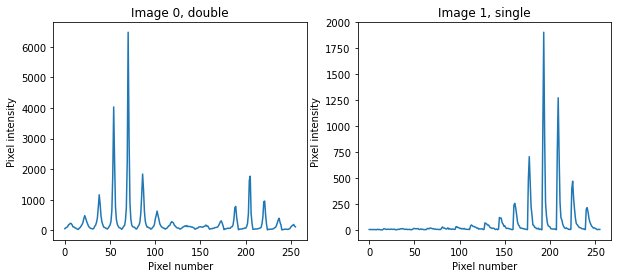

In [31]:
# Plot the two pixel arrays side by side
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(images[0])
ax[0].set_title("Image 0, double")
ax[0].set_xlabel("Pixel number")
ax[0].set_ylabel("Pixel intensity")

ax[1].plot(images[1])
ax[1].set_title("Image 1, single")
ax[1].set_xlabel("Pixel number")
ax[1].set_ylabel("Pixel intensity")

The plots above don't look like images, but we can still see a difference between them. 
Image 0 looks like it has two peaks, while image 1 looks like it only has one. 
Let's plot it like an actual image (or matrix), the way the detector is set up, instead.

By default, the color of each pixel in the following plot is related to the pixel's value,
but the value itself isn't displayed. So we're going to add a "colorbar" to each image that gives
us that information. Additionaly, we will plot the position of the events as a red "x", to see if it matches.

In our data, a single image is currently just a flat array of pixels. To plot it as an image, we must reshape it.
This is a simple task when it's a numpy array, using a built-in function for arrays called "reshape". We will
reshape the image to 16x16 pixels.

Convention in this case is to plot the detector image with origins in the lower left, like a standard coordinate
system. (This can be different from research group to research group). We specify this by passing the keyword "origin" to imshow. 

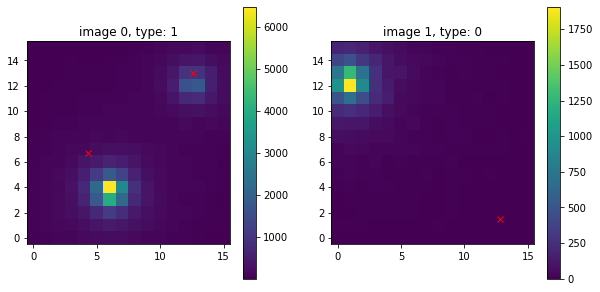

In [32]:
# Plot detector image, including positions and a colorbar.
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
image_0 = ax[0].imshow(images[0].reshape(16, 16), origin='lower')
ax[0].plot(positions[0, 0], positions[0, 1], 'rx')
ax[0].plot(positions[0, 2], positions[0, 3], 'rx')
ax[0].set_title("image 0, type: " + str(labels[0]))
fig.colorbar(image_0, ax=ax[0])

image_1 = ax[1].imshow(images[1].reshape(16, 16), origin='lower')
ax[1].set_title("image 1, type: " + str(labels[1]))
ax[1].plot(positions[1, 0], positions[1, 1], 'rx')
fig.colorbar(image_1, ax=ax[1])
plt.show()

Something is definitely not right with the positions here. It looks like the coordinates are flipped, especially
when looking at the right image. This can be a result of the conversion from a flattened image to a 16x16 image,
if it doesn't exactly reverse the way the image was originally written to file. One such case could be that the
image was written to file in a column-major fashion. There are at least three ways we can correct this:
* Reshape the arrays and specify the order (check numpy reshape documentation)
* Transpose the reshaped arrays
* Swap the x and y positions

Transposing is very fast, so we'll go with that one this time.
Let's plot the images again. With numpy you can get the transpose of an array as an attribute,
".T". Recall also the positions and energies we printed above:
```
Label of image 0: 1
Positions: [ 4.30804  6.70703 12.6208  13.0421 ]
Energies: [0.942514 0.33576 ]

Label of image 1: 0
Positions: [  12.7629     1.52259 -100.      -100.     ]
Energies: [0.302704 0.      ]
```

In [33]:
# Rehape the whole set of images
images = images.reshape((images.shape[0], 16, 16))

# Transpose all the images
images = np.transpose(images, (0, 2, 1))

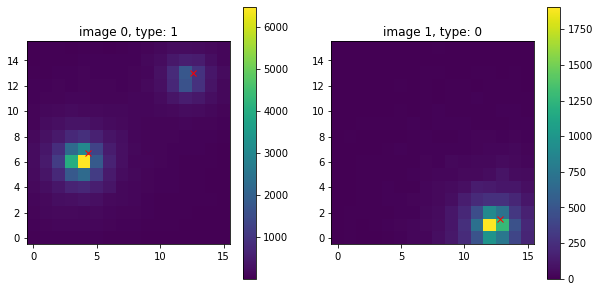

In [34]:
# Plot TRANSPOSED detector image, including positions and a colorbar
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
image_0 = ax[0].imshow(images[0], origin='lower')
ax[0].plot(positions[0, 0], positions[0, 1], 'rx')
ax[0].plot(positions[0, 2], positions[0, 3], 'rx')
ax[0].set_title("image 0, type: " + str(labels[0]))
fig.colorbar(image_0, ax=ax[0])

image_1 = ax[1].imshow(images[1], origin='lower')
ax[1].set_title("image 1, type: " + str(labels[1]))
ax[1].plot(positions[1, 0], positions[1, 1], 'rx')
fig.colorbar(image_1, ax=ax[1])

This looks much, much better. The positions fit, and the corresponding energies in the left image match the
difference in pixel intensity. Most likely the simulation software is written with a slightly different
convention than the way we read the file by default.

You could also ask the question "does it matter"?\
Actually, for classification purposes it probably doesn't, because we want to know how many events there
are in one image, rather than where they are. At least, we don't *want* the event position to matter when
we're classifying, as that would indicate poor generalisation, or a bias in the distribution of events.

## Looking further
It's not just the detector images themselves that are subject to some analysis before we start training.
Our target values - energies, positions, labels - are also of interest. These can reveal other aspects of
the data that we must take into account. Some questions that can be asked here are:
* Is the dataset balanced?
* What is the distribution of event energies?
* What is the distribution of positions?
* Are there differences between double and single events regarding these distributions?

Then there's aggregated data, such as the separation distance between two detected particles in
a double event. Are these evenly distributed?
We'll try to answer these questions one by one.

### Is the dataset balanced?
To determine this we can simply count the number of occurences for each label.

In [36]:
unique, counts = np.unique(labels, return_counts=True)
print("Number of single events:", counts[0])
print("Number of double events:", counts[1]) 

Number of single events: 5002
Number of double events: 4998


In the file with 10k events we have 5002 single events and 4998 double events, so we should we very much good to go!

### What is the distribution of event energies?
To look at single events and double events separately, we need to create two sets of indices.
Given an array a, the condition a > 3 is a boolean array and since False is interpreted as 0, [np.nonzero](https://numpy.org/doc/stable/reference/generated/numpy.nonzero.html#numpy.nonzero)(a > 3) yields the indices of the a where the condition is true.

Because all the arrays of data we've created are ordered identically, we can use these indices across
all our arrays to keep single and double events separated if we want.

In [45]:
# Make index arrays. np.nonzero returns a tuple where the first element is our index array.
singles = np.nonzero(labels == 0)[0]
doubles = np.nonzero(labels == 1)[0]

# Check their length
print("Singles:", singles.shape, " | Doubles:", doubles.shape)

Singles: (5002,)  | Doubles: (4998,)


Next we'll plot histograms of the energies in single and double events. Keep in mind that the energy array
is (E1, E2), so for single events we must specify that we're only interested in the column containing E1.

Text(0, 0.5, 'Observations')

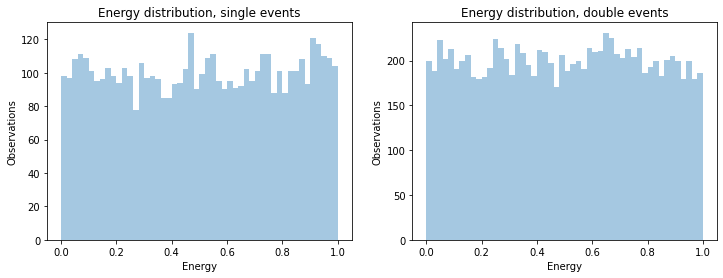

In [60]:
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.distplot(energies[singles, 0], bins=50, kde=False, ax=ax[0])
ax[0].set_title("Energy distribution, single events")
ax[0].set_xlabel("Energy")
ax[0].set_ylabel("Observations")

sns.distplot(energies[doubles], bins=50, kde=False, ax=ax[1])
ax[1].set_title("Energy distribution, double events")
ax[1].set_xlabel("Energy")
ax[1].set_ylabel("Observations")

Fairly uniform.

### What is the distribution of positions?
On way to look at this is by using a scatterplot of positions. If the positions are also
fairly uniform in their distribution, the scatterplot should resemple a square with size about equal
to a detector image.

Text(0, 0.5, 'Y [pixels]')

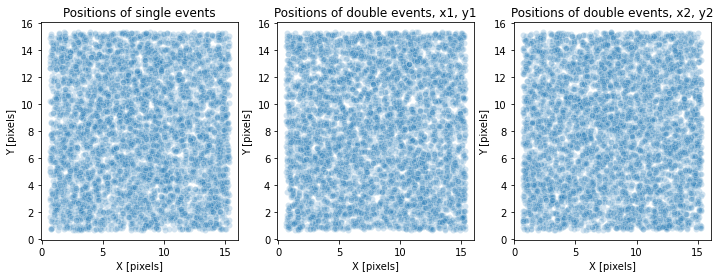

In [75]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.scatterplot(positions[singles, 0], positions[singles, 1], alpha=0.2, ax=ax[0])
ax[0].set_title("Positions of single events")
ax[0].set_xlabel("X [pixels]")
ax[0].set_ylabel("Y [pixels]")

sns.scatterplot(positions[doubles, 0], positions[doubles, 1], alpha=0.2, ax=ax[1])
ax[1].set_title("Positions of double events, x1, y1")
ax[1].set_xlabel("X [pixels]")
ax[1].set_ylabel("Y [pixels]")

sns.scatterplot(positions[doubles, 2], positions[doubles, 3], alpha=0.2, ax=ax[2])
ax[2].set_title("Positions of double events, x2, y2")
ax[2].set_xlabel("X [pixels]")
ax[2].set_ylabel("Y [pixels]")

Also fairly uniform.

### Double-event specifics
For double events there are a couple more things we can explore. Separation distances, as mentioned above,
and also the relative energy. Let's calculate those and plot them, too.

#### Separation distances
We will simply use the euclidian distance between two points. A quick recap - if $p = (p_0,p_1)$
and $q = (q_0,q_1)$ are the two points, then the distance $d(p,q)$ between them is given by
$$d(\mathbf{p},\mathbf{q})=\sqrt{(q_0-p_0)^2 + (q_1-p_1)^2}$$

In [78]:
# Calculate separation distances for double events
separation_distance = np.sqrt(
    (positions[doubles, 2] - positions[doubles, 0])**2
    + (positions[doubles, 3] - positions[doubles, 1])**2
)

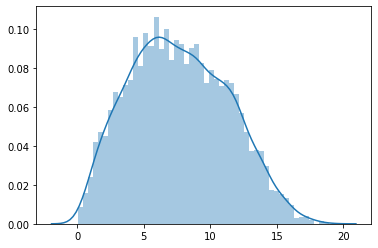

In [83]:
# Plot distribution of separation distances
sns.distplot(separation_distance, bins=50)

#### Relative energy
We can also look at how the relative energy is distributed. The quickest way to do this is the
following

$$E_{\text{relative}} = \frac{E_1}{E_2}$$

In [85]:
# Calculate relative energies
e_relative = energies[doubles, 0] / energies[doubles, 1]

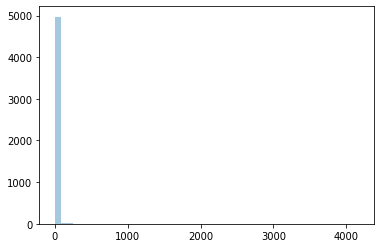

In [96]:
# Plot distribution of relative energies
fig, ax = plt.subplots()
sns.distplot(e_relative, kde=False, ax=ax)
ax.set_title("Distribution of relative energies")
ax.set_xlabel("Energy")
ax.set_ylabel("Occurences")

Okay, that is not a very useful plot. Looks like we get some relative energies that are very large compared
to the majority. Let's see how many are above 10, between 1 and 10, and below 1.

In [130]:
# Indices for the intervals.
above_ten = np.nonzero(e_relative > 10)[0]
e_tmp = e_relative[np.nonzero(e_relative >= 1)]
one_to_ten = np.nonzero(e_tmp <= 10)[0]
less_than_one = np.nonzero(e_relative < 1)[0]
print("Events with e_relative > 10:", above_ten.shape[0])
print("Events with 1 <= e_relative <= 10:", one_to_ten.shape[0])
print("Events with e_relative < 1:", less_than_one.shape[0])

Events with e_relative > 10: 253
Events with 1 <= e_relative <= 10: 2290
Events with e_relative < 1: 2455


We have 253 out of 5000 events that are above 10, and roughly half the events are between 1 and 10.
So we're going to split these relative energies into three plots. [0, 1), [1, 10] and (10, ...]

Text(0, 0.5, 'Occurences')

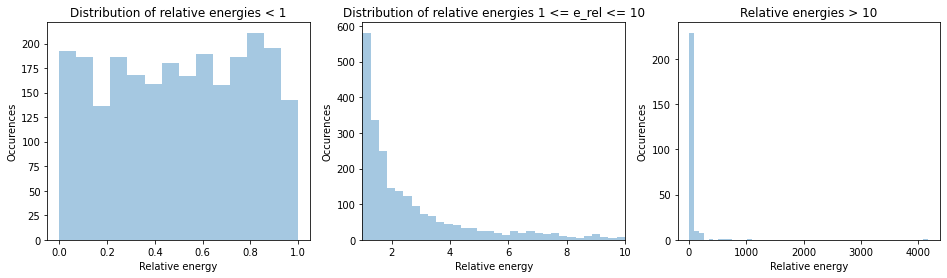

In [139]:
# Plot distribution of relative energies for events with relative energy <= 10
# We use the boolean array to get these events, e_relative[e_relative <= 10] reads as
# "The elements of e_relative on the indices where e_relative <= 10 is True"
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
sns.distplot(e_relative[less_than_one], kde=False, ax=ax[0])
ax[0].set_title("Distribution of relative energies < 1")
ax[0].set_xlabel("Relative energy")
ax[0].set_ylabel("Occurences")
sns.distplot(e_tmp[one_to_ten], kde=False, ax=ax[1])
ax[1].set_title("Distribution of relative energies 1 <= e_rel <= 10")
ax[1].set_xlabel("Relative energy")
ax[1].set_ylabel("Occurences")
ax[1].set_xlim([1, 10])
sns.distplot(e_relative[above_ten], kde=False, ax=ax[2])
ax[2].set_title("Relative energies > 10")
ax[2].set_xlabel("Relative energy")
ax[2].set_ylabel("Occurences")

This tells us that most evens have a relative energy of up to 10, as a relative energy of less than 0.1 is
effectively the same as a relative energy of above 10, since we always device E1/E2. 

In [141]:
print("0.5 to 1:", np.nonzero(e_relative[less_than_one] >= 0.5)[0].shape[0])
print("1.0 to 2:", np.nonzero(e_relative[one_to_ten] < 2.0)[0].shape[0])

0.5 to 1: 1248
1.0 to 2: 1695


## Separate and save the data
First, we separate the data into a *training set* and a *test set*. The test set will be used to give us an "out-of-sample"
accuracy. To do this properly, the model will never see the test set in any way, shape, or form before we've trained, evaluated, and optimized it as far as we'd like to go. In other words, we use the training set to make the model as good as possible, and only then do we predict on the test set and report out-of-sample metrics.

You can do the splitting of data manually by slicing the arrays, but scikit-learn has it's own function for doing this,
[train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train_test_split#sklearn.model_selection.train_test_split).
Instead of creating copies of the dataset, filling up often precious memory, we will work with indices that we
pass around. This also makes it easier to trace any results back to the original inputs.

### Numpy format

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
# Indices for all data
x_idx = np.arange(images.shape[0])

# Split the indices into training and test sets (take out 20% of the data as test)
train_idx, test_idx, not_used1, not_used2 = train_test_split(x_idx, x_idx, test_size = 0.2)

# Save the training and test data in the data folder
# We also need to save the labels, energies, and positions. This allows us to
# quickly load it if we need it.

# Save the training data. np.save adds a ".npy" file extension to the provided filename.
# We save the files in the same folder as the original datafile.
np.save(DATA_PATH + "images_training", images[train_idx])
np.save(DATA_PATH + "energies_training", energies[train_idx])
np.save(DATA_PATH + "positions_training", positions[train_idx])
np.save(DATA_PATH + "labels_training", labels[train_idx])

# Save the test data
np.save(DATA_PATH + "images_test", images[test_idx])
np.save(DATA_PATH + "energies_test", energies[test_idx])
np.save(DATA_PATH + "positions_test", positions[test_idx])
np.save(DATA_PATH + "labels_test", labels[test_idx])

You could also opt to store the entire training and test sets as two files, by concatenating them.
This is just personal preference.

### hdf5 format

In [20]:
import h5py

In [21]:
# Open separate files for saving training and test datasets
data_training = h5py.File(DATA_PATH + "data_training.hdf5", "w")
data_test = h5py.File(DATA_PATH + "data_test.hdf5", "w")

# Training data
data_training.create_dataset('images', data=images[train_idx])
data_training.create_dataset('energies', data=energies[train_idx])
data_training.create_dataset('positions', data=positions[train_idx])
data_training.create_dataset('labels', data=labels[train_idx])
data_training.close()

# Test data
data_test.create_dataset('images', data=images[test_idx])
data_test.create_dataset('energies', data=energies[test_idx])
data_test.create_dataset('positions', data=positions[test_idx])
data_test.create_dataset('labels', data=labels[test_idx])
data_test.close()